**DATA SYSTHESIS AUGMENTATION PREPARATION ON(VAR AND SDV COMPARISON)**

DIMENSIONALITY REDUCTION

In [3]:
# --- Essential Installs ---
!pip install numpy pandas matplotlib scikit-learn # Ensure scikit-learn is installed

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle # For saving scaler/PCA objects
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Mount Google Drive (if using Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
    # Define base path for saving output files
    gdrive_output_base = "/content/drive/MyDrive/" # Adjust if you want a subfolder
except ImportError:
    print("Not running in Colab or Drive mounting failed. Saving locally.")
    gdrive_output_base = "./" # Save to current directory if not on Colab/Drive

# --- Configuration ---
# File paths for input data
filepath_orig = "/content/drive/MyDrive/tft_ready_data_darts.csv"
filepath_july = "/content/drive/MyDrive/tft_ready_data_darts_JULY.csv"
filepath_new1 = "/content/drive/MyDrive/tft_ready_data_darts_AUG.csv"
filepath_new2 = "/content/drive/MyDrive/tft_ready_data_darts_SEP.csv"
filepath_new3 = "/content/drive/MyDrive/tft_ready_data_darts_OCT.csv"

# PCA Configuration
pca_variance_threshold = 0.95

# Train/Validation Split Configuration
validation_set_size = 0.2
split_random_state = 42

# *** SAVE Configuration ***
output_directory_name = "PCA_Output_Data" # Name of the folder for PCA results
save_pca_output = True # Set to False to disable saving
# --- Filenames ---
train_data_filename = "train_data_pca_reduced.csv"
val_data_filename = "val_data_pca_reduced.csv"
target_cols_filename = "target_cols.txt"
future_cols_filename = "future_covariate_cols.txt"
past_pca_cols_filename = "past_covariate_cols_reduced.txt"
scaler_filename = "past_cov_scaler_pca.pkl"
pca_filename = "pca_object.pkl"

# Construct full output path
output_dir = os.path.join(gdrive_output_base, output_directory_name)
# *** End SAVE Configuration ***


# --- 1. Load AND COMBINE Preprocessed Data ---
print("--- Step 1: Loading and Combining Original Data ---")
# ... (Keep the robust loading loop from the previous script) ...
all_dfs = []
file_paths = [filepath_orig, filepath_july, filepath_new1, filepath_new2, filepath_new3]
for i, fp in enumerate(file_paths):
    print(f"Loading data from file {i+1}: {fp}")
    if not os.path.exists(fp): print(f"Error: File not found at {fp}. Skipping."); continue
    try:
        df_temp = pd.read_csv(fp, parse_dates=['date'], index_col='date')
        if not isinstance(df_temp.index, pd.DatetimeIndex): df_temp.index = pd.to_datetime(df_temp.index)
        if 'date' in df_temp.columns: df_temp = df_temp.drop(columns=['date'])
        all_dfs.append(df_temp)
        print(f"  - Loaded shape: {df_temp.shape}")
    except Exception as e: print(f"Error loading CSV {fp}: {e}. Skipping.")
if not all_dfs: print("Error: No data files loaded."); exit()
df_original = pd.concat(all_dfs, axis=0)

# --- 2. Initial Data Cleaning and Verification ---
print("\n--- Step 2: Initial Data Cleaning ---")
# ... (Keep cleaning logic: ffill/bfill, replace inf, sort, drop duplicates) ...
print(f"Shape after concat: {df_original.shape}")
df_original = df_original.ffill().bfill()
df_original.replace([np.inf, -np.inf], 0, inplace=True)
df_original = df_original.sort_index()
initial_len = len(df_original)
if not df_original.index.is_unique:
    print("Warning: Duplicate dates found. Keeping first occurrence.")
    df_original = df_original[~df_original.index.duplicated(keep='first')]
    print(f"  - Removed {initial_len - len(df_original)} duplicate date rows.")
print(f"\nOriginal data processed. Shape: {df_original.shape}")
if not isinstance(df_original.index, pd.DatetimeIndex): print("Error: Final index not DatetimeIndex."); exit()

# --- 3. Identify Column Types ---
print("\n--- Step 3: Identifying Column Types ---")
# ... (Keep column identification logic) ...
if 'time_idx' not in df_original.columns: df_original['time_idx'] = (df_original.index - df_original.index.min()).days
target_cols = sorted([col for col in df_original.columns if col.startswith('target_')])
future_covariate_cols = sorted([col for col in df_original.columns if col.startswith('future_')])
known_non_past_cols = set(target_cols + future_covariate_cols + ['time_idx'])
past_covariate_cols = sorted([col for col in df_original.columns if col not in known_non_past_cols])
if not target_cols: raise ValueError("No 'target_' columns.")
if not past_covariate_cols: raise ValueError("No past covariate columns.")
print(f"Identified {len(target_cols)} targets, {len(future_covariate_cols)} future, {len(past_covariate_cols)} past covariates.")

# --- 4. Split Data into Training and Validation Sets ---
print("\n--- Step 4: Splitting Data into Train/Validation ---")
# ... (Keep train_test_split logic with shuffle=False) ...
try:
    train_df, val_df = train_test_split(df_original, test_size=validation_set_size, shuffle=False)
    print(f"Training set shape: {train_df.shape}, Validation set shape: {val_df.shape}")
except Exception as e: print(f"Error during split: {e}"); raise

# --- 5. Isolate and Scale Past Covariates ---
print("\n--- Step 5: Scaling Past Covariates ---")
# ... (Keep scaling logic, fitting scaler on train_df[past_covariate_cols]) ...
X_train_past = train_df[past_covariate_cols].copy().fillna(0)
X_val_past = val_df[past_covariate_cols].copy().fillna(0)
scaler = StandardScaler()
print("Fitting Scaler on training data...")
scaler.fit(X_train_past)
print("Transforming training and validation data...")
X_train_past_scaled = scaler.transform(X_train_past)
X_val_past_scaled = scaler.transform(X_val_past)
print(f"Scaled shapes: Train {X_train_past_scaled.shape}, Val {X_val_past_scaled.shape}")


# --- 6. Apply PCA for Dimensionality Reduction ---
print("\n--- Step 6: Applying PCA ---")
# ... (Keep PCA variance exploration and final application logic) ...
print("Exploring explained variance...")
pca_explorer = PCA(n_components=None); pca_explorer.fit(X_train_past_scaled)
cumulative_variance = np.cumsum(pca_explorer.explained_variance_ratio_)
n_components_final = np.argmax(cumulative_variance >= pca_variance_threshold) + 1
print(f"Components for {pca_variance_threshold*100:.0f}% variance: {n_components_final}")
# Optional plot...
print(f"Applying PCA with {n_components_final} components...")
pca = PCA(n_components=n_components_final); pca.fit(X_train_past_scaled)
X_train_past_pca = pca.transform(X_train_past_scaled)
X_val_past_pca = pca.transform(X_val_past_scaled)
print(f"PCA reduction shapes: Train {X_train_past_pca.shape}, Val {X_val_past_pca.shape}")
pca_columns = [f'PC_{i+1}' for i in range(n_components_final)]
df_train_past_pca = pd.DataFrame(X_train_past_pca, index=X_train_past.index, columns=pca_columns)
df_val_past_pca = pd.DataFrame(X_val_past_pca, index=X_val_past.index, columns=pca_columns)

# --- 7. Reconstruct Final DataFrames ---
print("\n--- Step 7: Reconstructing Final DataFrames with Reduced Past Covariates ---")
# ... (Keep reconstruction logic using df_train_past_pca and df_val_past_pca) ...
df_train_reduced = pd.concat([train_df[target_cols], train_df[future_covariate_cols], df_train_past_pca], axis=1).fillna(0)
df_val_reduced = pd.concat([val_df[target_cols], val_df[future_covariate_cols], df_val_past_pca], axis=1).fillna(0)
print(f"Final Reduced Training DataFrame shape: {df_train_reduced.shape}")
print(f"Final Reduced Validation DataFrame shape: {df_val_reduced.shape}")
past_covariate_cols_reduced = pca_columns # Update the list name

# --- 8. Save Reduced Data and Objects ---
print("\n--- Step 8: Saving PCA Results ---")
if save_pca_output:
    try:
        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        print(f"Ensured output directory exists: {output_dir}")

        # --- Save DataFrames ---
        train_save_path = os.path.join(output_dir, train_data_filename)
        val_save_path = os.path.join(output_dir, val_data_filename)
        print(f"Saving reduced training data to: {train_save_path}")
        df_train_reduced.to_csv(train_save_path, index=True) # Save with index
        print(f"Saving reduced validation data to: {val_save_path}")
        df_val_reduced.to_csv(val_save_path, index=True) # Save with index

        # --- Save Column Lists ---
        def save_list_to_file(data_list, filename):
            path = os.path.join(output_dir, filename)
            print(f"Saving list to: {path}")
            with open(path, 'w') as f:
                for item in data_list:
                    f.write(f"{item}\n")

        save_list_to_file(target_cols, target_cols_filename)
        save_list_to_file(future_covariate_cols, future_cols_filename)
        save_list_to_file(past_covariate_cols_reduced, past_pca_cols_filename)

        # --- Save Scaler and PCA Objects ---
        scaler_save_path = os.path.join(output_dir, scaler_filename)
        pca_save_path = os.path.join(output_dir, pca_filename)

        print(f"Saving fitted scaler object to: {scaler_save_path}")
        with open(scaler_save_path, 'wb') as f:
            pickle.dump(scaler, f)

        print(f"Saving fitted PCA object to: {pca_save_path}")
        with open(pca_save_path, 'wb') as f:
            pickle.dump(pca, f)

        print("All PCA results saved successfully.")

    except Exception as e:
        print(f"Error saving PCA results: {e}")
else:
    print("Saving PCA output disabled (save_pca_output=False).")


print("\nPCA script finished.")
print("Variables `df_train_reduced`, `df_val_reduced`, `target_cols`, `future_covariate_cols`, `past_covariate_cols_reduced` are ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
--- Step 1: Loading and Combining Original Data ---
Loading data from file 1: /content/drive/MyDrive/tft_ready_data_darts.csv
  - Loaded shape: (31, 493)
Loading data from file 2: /content/drive/MyDrive/tft_ready_data_darts_JULY.csv
  - Loaded shape: (32, 514)
Loading data from file 3: /content/drive/MyDrive/tft_ready_data_darts_AUG.csv
  - Loaded shape: (32, 514)
Loading data from file 4: /content/drive/MyDrive/tft_ready_data_darts_SEP.csv
  - Loaded shape: (31, 514)
Loading data from file 5: /content/drive/MyDrive/tft_ready_data_darts_OCT.csv
  - Loaded shape: (32, 514)

--- Step 2: Initial Data Cleaning ---
Shape after concat: (158, 525)
  - Removed 4 duplicate date rows.

Original data processed. Shape: (154, 525)

--- Step 3: Identifying Column Types ---
Identified 12 targets, 5 future, 507 past covariates.

--- Step 4:

RANDOM FOREST FEATURE REDUCTION

In [1]:
# --- Essential Installs ---
!pip install numpy pandas matplotlib scikit-learn # Ensure scikit-learn is installed

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # Import RandomForest
from sklearn.preprocessing import StandardScaler

# --- Mount Google Drive (if using Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
    # Define base path for saving output files
    gdrive_output_base = "/content/drive/MyDrive/" # Adjust if you want a subfolder
except ImportError:
    print("Not running in Colab or Drive mounting failed. Saving locally.")
    gdrive_output_base = "./"

# --- Configuration ---
# File paths for input data
filepath_orig = "/content/drive/MyDrive/tft_ready_data_darts.csv"
filepath_july = "/content/drive/MyDrive/tft_ready_data_darts_JULY.csv"
filepath_new1 = "/content/drive/MyDrive/tft_ready_data_darts_AUG.csv"
filepath_new2 = "/content/drive/MyDrive/tft_ready_data_darts_SEP.csv"
filepath_new3 = "/content/drive/MyDrive/tft_ready_data_darts_OCT.csv"

# Feature Importance Configuration
n_features_to_keep = 50 # How many top past covariates to select
rf_n_estimators = 100   # Number of trees in RandomForest
rf_max_depth = 15       # Max depth of trees (controls complexity)
rf_max_features = 'sqrt'# Number of features to consider at each split
rf_n_jobs = -1          # Use all available CPU cores
rf_random_state = 42

# Train/Validation Split Configuration
validation_set_size = 0.2
split_random_state = 42 # Still relevant for potential internal randomness if shuffle=True used elsewhere

# *** SAVE Configuration ***
output_directory_name = "Feature_Selection_Output" # Folder for results
save_fs_output = True # Set to False to disable saving
# --- Filenames ---
train_data_filename = "train_data_rf_selected.csv" # Changed filename
val_data_filename = "val_data_rf_selected.csv"   # Changed filename
target_cols_filename = "target_cols.txt"
future_cols_filename = "future_covariate_cols.txt"
selected_past_cols_filename = "past_covariates_selected_rf.txt" # Changed filename
scaler_filename = "past_cov_scaler_rf.pkl" # Scaler fitted on original past covs

# Construct full output path
output_dir = os.path.join(gdrive_output_base, output_directory_name)
# *** End SAVE Configuration ***


# --- 1. Load AND COMBINE Preprocessed Data ---
print("--- Step 1: Loading and Combining Original Data ---")
# (Keep the robust loading loop - same as PCA script)
all_dfs = []
file_paths = [filepath_orig, filepath_july, filepath_new1, filepath_new2, filepath_new3]
for i, fp in enumerate(file_paths):
    print(f"Loading data from file {i+1}: {fp}")
    if not os.path.exists(fp): print(f"Error: File not found at {fp}. Skipping."); continue
    try:
        df_temp = pd.read_csv(fp, parse_dates=['date'], index_col='date')
        if not isinstance(df_temp.index, pd.DatetimeIndex): df_temp.index = pd.to_datetime(df_temp.index)
        if 'date' in df_temp.columns: df_temp = df_temp.drop(columns=['date'])
        all_dfs.append(df_temp)
        print(f"  - Loaded shape: {df_temp.shape}")
    except Exception as e: print(f"Error loading CSV {fp}: {e}. Skipping.")
if not all_dfs: print("Error: No data files loaded."); exit()
df_original = pd.concat(all_dfs, axis=0)

# --- 2. Initial Data Cleaning and Verification ---
print("\n--- Step 2: Initial Data Cleaning ---")
# (Keep cleaning logic - same as PCA script)
print(f"Shape after concat: {df_original.shape}")
df_original = df_original.ffill().bfill()
df_original.replace([np.inf, -np.inf], 0, inplace=True)
df_original = df_original.sort_index()
initial_len = len(df_original)
if not df_original.index.is_unique:
    print("Warning: Duplicate dates found. Keeping first occurrence.")
    df_original = df_original[~df_original.index.duplicated(keep='first')]
    print(f"  - Removed {initial_len - len(df_original)} duplicate date rows.")
print(f"\nOriginal data processed. Shape: {df_original.shape}")
if not isinstance(df_original.index, pd.DatetimeIndex): print("Error: Final index not DatetimeIndex."); exit()

# --- 3. Identify Column Types ---
print("\n--- Step 3: Identifying Column Types ---")
# (Keep column identification logic - same as PCA script)
if 'time_idx' not in df_original.columns: df_original['time_idx'] = (df_original.index - df_original.index.min()).days
target_cols = sorted([col for col in df_original.columns if col.startswith('target_')])
future_covariate_cols = sorted([col for col in df_original.columns if col.startswith('future_')])
known_non_past_cols = set(target_cols + future_covariate_cols + ['time_idx'])
past_covariate_cols = sorted([col for col in df_original.columns if col not in known_non_past_cols]) # ORIGINAL past covariates
if not target_cols: raise ValueError("No 'target_' columns.")
if not past_covariate_cols: raise ValueError("No original past covariate columns found.")
print(f"Identified {len(target_cols)} targets, {len(future_covariate_cols)} future, {len(past_covariate_cols)} original past covariates.")

# --- 4. Split Data into Training and Validation Sets ---
print("\n--- Step 4: Splitting Data into Train/Validation ---")
# (Keep train_test_split logic - same as PCA script)
try:
    train_df, val_df = train_test_split(df_original, test_size=validation_set_size, shuffle=False)
    print(f"Training set shape: {train_df.shape}, Validation set shape: {val_df.shape}")
except Exception as e: print(f"Error during split: {e}"); raise

# --- 5. Prepare Training Data & Scale Original Past Covariates ---
print("\n--- Step 5: Preparing & Scaling Training Data for Importance Calculation ---")
X_train_past = train_df[past_covariate_cols].copy()
y_train_targets = train_df[target_cols].copy()

# Handle potential NaNs before scaling/fitting
print("Handling NaNs in training data...")
X_train_past = X_train_past.fillna(X_train_past.mean()) # Impute with mean
y_train_targets = y_train_targets.fillna(y_train_targets.mean())
if X_train_past.isnull().sum().sum() > 0: print("Warning: NaNs remain in X_train_past after imputation.")
if y_train_targets.isnull().sum().sum() > 0: print("Warning: NaNs remain in y_train_targets after imputation.")

# Scale the ORIGINAL past covariates (fit on train)
print("Scaling original past covariates (fit on train)...")
scaler_fs = StandardScaler() # Scaler for feature selection step
X_train_past_scaled = scaler_fs.fit_transform(X_train_past)
print(f"Scaled training past covariates shape: {X_train_past_scaled.shape}")

# --- 6. Calculate Feature Importance using RandomForest ---
print("\n--- Step 6: Calculating Feature Importance per Target ---")
all_importances = {} # Dictionary to store importance scores per target

start_time_fs = time.time()
for i, target_name in enumerate(target_cols):
    print(f"  ({i+1}/{len(target_cols)}) Training RF for target: {target_name} ...")
    y_target_current = y_train_targets[target_name]

    rf_model = RandomForestRegressor(
        n_estimators=rf_n_estimators, max_depth=rf_max_depth, max_features=rf_max_features,
        random_state=rf_random_state, n_jobs=rf_n_jobs, oob_score=False )
    rf_model.fit(X_train_past_scaled, y_target_current)
    all_importances[target_name] = rf_model.feature_importances_

end_time_fs = time.time()
print(f"Feature importance calculation complete. Time taken: {end_time_fs - start_time_fs:.2f} seconds")

# --- 7. Aggregate Importance and Select Top Features ---
print("\n--- Step 7: Aggregating Importance and Selecting Top Features ---")
importance_matrix = pd.DataFrame(all_importances, index=past_covariate_cols)
mean_importance = importance_matrix.mean(axis=1)
aggregated_importance_df = pd.DataFrame({'Feature': mean_importance.index, 'MeanImportance': mean_importance.values})
aggregated_importance_df = aggregated_importance_df.sort_values(by='MeanImportance', ascending=False).reset_index(drop=True)

print("Top 20 Features by Mean Importance Across All Targets:")
print(aggregated_importance_df.head(20))

if n_features_to_keep > len(aggregated_importance_df):
    print(f"Warning: n_features_to_keep ({n_features_to_keep}) > total features ({len(aggregated_importance_df)}). Keeping all features.")
    n_features_to_keep = len(aggregated_importance_df)

# This list contains the NAMES of the selected ORIGINAL past covariates
selected_past_features = aggregated_importance_df['Feature'].head(n_features_to_keep).tolist()
print(f"\nSelected the top {len(selected_past_features)} past covariate features based on mean importance.")
print("Sample of selected features:", selected_past_features[:10])

# --- 8. Reconstruct Final DataFrames with Selected Features ---
print("\n--- Step 8: Reconstructing Final DataFrames with Selected Features ---")
# Select the target, future, and SELECTED ORIGINAL past features
cols_to_keep = target_cols + future_covariate_cols + selected_past_features

# Create the reduced dataframes by selecting columns
df_train_rf_reduced = train_df[cols_to_keep].copy()
df_val_rf_reduced = val_df[cols_to_keep].copy()

print(f"Final RF-Selected Training DataFrame shape: {df_train_rf_reduced.shape}")
print(f"Final RF-Selected Validation DataFrame shape: {df_val_rf_reduced.shape}")

# --- 9. Save Feature Selection Results ---
print("\n--- Step 9: Saving Feature Selection Results ---")
if save_fs_output:
    try:
        os.makedirs(output_dir, exist_ok=True)
        print(f"Ensured output directory exists: {output_dir}")

        # --- Save Reduced DataFrames ---
        train_save_path = os.path.join(output_dir, train_data_filename)
        val_save_path = os.path.join(output_dir, val_data_filename)
        print(f"Saving RF-selected training data to: {train_save_path}")
        df_train_rf_reduced.to_csv(train_save_path, index=True)
        print(f"Saving RF-selected validation data to: {val_save_path}")
        df_val_rf_reduced.to_csv(val_save_path, index=True)

        # --- Save Column Lists ---
        def save_list_to_file(data_list, filename):
            path = os.path.join(output_dir, filename)
            print(f"Saving list to: {path}")
            with open(path, 'w') as f: [f.write(f"{item}\n") for item in data_list]

        save_list_to_file(target_cols, target_cols_filename)
        save_list_to_file(future_covariate_cols, future_cols_filename)
        # Save the list of SELECTED past covariate names
        save_list_to_file(selected_past_features, selected_past_cols_filename)

        # --- Save the Scaler Used for Importance Calculation ---
        scaler_save_path = os.path.join(output_dir, scaler_filename)
        print(f"Saving fitted scaler object (used for RF) to: {scaler_save_path}")
        with open(scaler_save_path, 'wb') as f: pickle.dump(scaler_fs, f)

        print("All Feature Selection results saved successfully.")

    except Exception as e:
        print(f"Error saving Feature Selection results: {e}")
else:
    print("Saving Feature Selection output disabled (save_fs_output=False).")


print("\nFeature Selection script finished.")
print("List `selected_past_features` contains the names of the selected past covariates.")
print("If saving was enabled, reduced DataFrames and lists are in:", output_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
--- Step 1: Loading and Combining Original Data ---
Loading data from file 1: /content/drive/MyDrive/tft_ready_data_darts.csv
  - Loaded shape: (31, 493)
Loading data from file 2: /content/drive/MyDrive/tft_ready_data_darts_JULY.csv
  - Loaded shape: (32, 514)
Loading data from file 3: /content/drive/MyDrive/tft_ready_data_darts_AUG.csv
  - Loaded shape: (32, 514)
Loading data from file 4: /content/drive/MyDrive/tft_ready_data_darts_SEP.csv
  - Loaded shape: (31, 514)
Loading data from file 5: /content/drive/MyDrive/tft_ready_data_darts_OCT.csv
  - Loaded shape: (32, 514)

--- Step 2: Initial Data Cleaning ---
Shape after concat: (158, 525)
  - Removed 4 duplicate date rows.

Original data processed. Shape: (154, 525)

--- Step 3: Identifying Column Types ---
Identified 12 targets, 5 future, 507 original past covariates.

--

SDV TRIAL

In [ ]:
# --- Essential Installs ---
!pip install numpy pandas matplotlib # Ensure sdv is installed
!pip install --upgrade sdv
# !pip install --upgrade darts pytorch_lightning # Only if needed later

from sdv.metadata import Metadata
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# --- Mount Google Drive (if using Colab) ---
# Keep this if your files are on Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Colab or Drive mounting failed.")

# --- Configuration ---
# How many days of synthetic data to generate?
# Should match the length of the original training data or desired augmentation size
# Example: Use the length of the training data used for PCA
# n_synthetic_days = len(df_train_reduced) # Needs df_train_reduced from PCA script

# SDV Training parameters
sdv_epochs = 150 # Start moderate, increase later if needed (e.g., 300-500)
sdv_batch_size = 32

# --- Step 1: Load or Access PCA Reduced Data ---
print("--- Step 1: Accessing PCA-Reduced Training Data ---")

# !! IMPORTANT !!
# Assume the PCA script has run and these variables are available in the environment:
# - df_train_reduced: DataFrame with targets, future_covs, and PCA past_covs (PC_1, PC_2...)
# - target_cols: List of target column names
# - past_covariate_cols_reduced: List of PCA component column names ('PC_1', 'PC_2', ...)
# - future_covariate_cols: List of future covariate names (needed later for augmentation)

# --- Example Placeholder (Replace with loading if run separately) ---
try:
    # Check if variables exist from the previous PCA script run
    if 'df_train_reduced' in locals() and 'target_cols' in locals() and \
       'past_covariate_cols_reduced' in locals() and 'future_covariate_cols' in locals():
        print("Using df_train_reduced and column lists from previous PCA script.")
        n_synthetic_days = len(df_train_reduced) # Set based on training data length
    else:
        print("Error: PCA results (df_train_reduced, column lists) not found.")
        print("Please run the PCA script first or load the results.")
        # Example: Load from saved files if needed
        # df_train_reduced = pd.read_pickle("/path/to/df_train_reduced.pkl")
        # target_cols = ... # Load list
        # past_covariate_cols_reduced = ... # Load list
        # future_covariate_cols = ... # Load list
        # n_synthetic_days = len(df_train_reduced)
        raise NameError("PCA results not available.")

except NameError as e:
     raise e # Stop execution if data isn't loaded


print(f"Training SDV on data with shape: {df_train_reduced.shape}")
print(f"Using {len(target_cols)} target columns and {len(past_covariate_cols_reduced)} PCA past covariates.")

# --- Step 2: Prepare Data for SDV (Targets + PCA Past Covariates) ---
print("\n--- Step 2: Preparing Data for SDV ---")

# Select only target columns and the PCA-reduced past covariates
cols_for_synthesizer = target_cols + past_covariate_cols_reduced
print(f"Columns selected for SDV synthesizer training: {len(cols_for_synthesizer)} columns")

if not target_cols: # PCA cols should exist if script got this far
    raise ValueError("Error: No target columns identified for SDV training.")

# Reset index so 'date' becomes a regular column required by SDV
# Make sure the index of df_train_reduced is the DatetimeIndex
if not isinstance(df_train_reduced.index, pd.DatetimeIndex):
    print("Warning: Index of df_train_reduced is not DatetimeIndex. Attempting conversion if possible.")
    # This might indicate an issue in the PCA script's reconstruction step
    # df_train_reduced.index = pd.to_datetime(df_train_reduced.index) # Attempt conversion

df_for_sdv = df_train_reduced[cols_for_synthesizer].reset_index()
# Rename the index column consistently (e.g., to 'date')
date_col_name_sdv = df_for_sdv.columns[0] # Original index name
if date_col_name_sdv != 'date':
     print(f"Renaming index column from '{date_col_name_sdv}' to 'date' for SDV.")
     df_for_sdv = df_for_sdv.rename(columns={date_col_name_sdv: 'date'})
     date_col_name_sdv = 'date'

print(f"Data shape for SDV training: {df_for_sdv.shape}")
print(f"Columns for SDV: ['{date_col_name_sdv}'] + {cols_for_synthesizer[:3]}... ")


# --- Step 3: Define Metadata for SDV ---
print("\n--- Step 3: Defining SDV Metadata ---")
metadata = Metadata()

print("\n--- Pre-Metadata Detection Data Check & Cleaning ---")
print(f"Checking df_for_sdv (shape: {df_for_sdv.shape}) before detection...")

# 1. Check for NaNs / Infs again
nan_count = df_for_sdv.isnull().sum().sum()
inf_count = np.isinf(df_for_sdv.select_dtypes(include=np.number)).sum().sum()
print(f"NaN count: {nan_count}, Inf count: {inf_count}")
if nan_count > 0 or inf_count > 0:
    print("Applying final fillna(0) and replace(inf, 0)...")
    df_for_sdv = df_for_sdv.ffill().bfill() # Try ffill/bfill first
    df_for_sdv.fillna(0, inplace=True)     # Fill any remaining with 0
    df_for_sdv.replace([np.inf, -np.inf], 0, inplace=True)

# 2. Check Data Types (ensure targets and PCs are numeric)
print("Verifying data types...")
date_col_name_sdv = df_for_sdv.columns[0] # Assuming 'date' is first
all_numeric = True
for col in df_for_sdv.columns:
    if col == date_col_name_sdv:
        # Ensure date column is datetime
        if not pd.api.types.is_datetime64_any_dtype(df_for_sdv[col]):
             print(f"  Warning: Date column '{col}' is not datetime. Attempting conversion.")
             df_for_sdv[col] = pd.to_datetime(df_for_sdv[col], errors='coerce')
             if df_for_sdv[col].isnull().any():
                  print(f"  Error: Failed to convert date column '{col}' fully. Check data.")
                  all_numeric = False # Treat conversion failure as critical
    else:
        # Ensure other columns are numeric
        if not pd.api.types.is_numeric_dtype(df_for_sdv[col]):
            print(f"  Warning: Column '{col}' is not numeric ({df_for_sdv[col].dtype}). Attempting conversion.")
            df_for_sdv[col] = pd.to_numeric(df_for_sdv[col], errors='coerce')
            if df_for_sdv[col].isnull().any():
                 print(f"  Warning: Non-numeric values found in '{col}'. Filling introduced NaNs with 0.")
                 df_for_sdv[col].fillna(0, inplace=True)
        # Check for extreme values (optional, adjust bounds if needed)
        # min_val, max_val = df_for_sdv[col].min(), df_for_sdv[col].max()
        # if max_val > 1e12 or min_val < -1e12:
        #      print(f"  Warning: Potential extreme values in column '{col}' (Min: {min_val}, Max: {max_val})")


if not all_numeric:
     print("Error: Could not ensure all columns are appropriate types. Stopping.")
     exit()
else:
     print("Data types seem okay.")

print("Data check complete. Proceeding with metadata detection.")
# --- End Inserted Block ---

# --- Step 3: Define Metadata for SDV ---
print("\n--- Step 3: Defining SDV Metadata ---")
metadata = Metadata() # Ensure it's a fresh object
# --- 3a. Detect metadata ---
try:
    metadata.detect_from_dataframe(data=df_for_sdv)
    table_name = list(metadata.tables.keys())[0]
    print(f"Metadata detected. Default table name assigned: '{table_name}'")
except Exception as e:
     print(f"Error during metadata detection: {e}")
     raise

# --- 3b. Set sequence index ---
try:
    metadata.set_sequence_index(table_name=table_name, column_name=date_col_name_sdv)
    print(f"Sequence index for table '{table_name}' set to: '{date_col_name_sdv}'")
except Exception as e:
     print(f"Error setting sequence index '{date_col_name_sdv}' for table '{table_name}': {e}")
     raise

# --- 3c. Update date column type ---
try:
    metadata.update_column(
        table_name=table_name,
        column_name=date_col_name_sdv,
        sdtype='datetime',
        datetime_format='%Y-%m-%d %H:%M:%S' # Adjust format if needed based on your index
        # datetime_format='%Y-%m-%d' # Use if your index has no time part
    )
    print(f"Updated '{date_col_name_sdv}' sdtype to datetime for table '{table_name}'.")
except Exception as e:
    print(f"Warning: Could not update column '{date_col_name_sdv}' for table '{table_name}'. Auto-detected type might be used. Error: {e}")

# --- 3d. Verify/Update PCA columns (should be detected as numerical) ---
# Optional check: Ensure PC columns are treated as numerical floats
for col in past_covariate_cols_reduced:
    try:
        metadata.update_column(
             table_name=table_name, # Specify table name
             column_name=col,
             sdtype='numerical',
             computer_representation='Float'
        )
    except Exception as e:
        print(f"Warning: Could not update PCA column '{col}' type for table '{table_name}'. Error: {e}")
print(f"Data types for PCA columns verified/updated.")

# --- 3e. Verification ---
seq_index_check = metadata.get_sequence_index(table_name=table_name)
if seq_index_check:
    print(f"Metadata verification: Sequence index for table '{table_name}' is '{seq_index_check}'")
else:
    print(f"Warning: Sequence index for table '{table_name}' could not be verified after setting.")


# --- Step 4: Initialize and Train Synthesizer ---
print("\n--- Step 4: Initializing and Training PAR Synthesizer ---")
from sdv.sequential import PARSynthesizer # Ensure import is here

synthesizer = PARSynthesizer(metadata=metadata,
                           epochs=sdv_epochs,
                           # batch_size=sdv_batch_size, # Use default or set explicitly
                           verbose=True)

# Ensure no NaNs just before fitting
df_for_sdv_filled = df_for_sdv.ffill().bfill()
if df_for_sdv_filled.isnull().sum().sum() > 0:
    print("Warning: NaNs remain after ffill/bfill before fitting SDV.")
    df_for_sdv_filled.fillna(0, inplace=True) # Final fill with 0 if needed

print("Fitting SDV Synthesizer on PCA-reduced training data...")
start_time = time.time()
synthesizer.fit(df_for_sdv_filled)
end_time = time.time()
print(f"Synthesizer training complete. Time taken: {end_time - start_time:.2f} seconds")


# --- Step 5: Generate Synthetic Target and PCA Past Covariates ---
print("\n--- Step 5: Generating Synthetic Sequences ---")
print(f"Generating {n_synthetic_days} steps of synthetic targets and PCA past covariates...")

synthetic_sequences = synthesizer.sample(num_sequences=1,
                                         sequence_length=n_synthetic_days)

# Handle potential list output
if isinstance(synthetic_sequences, list):
     synthetic_tp_pca_df = synthetic_sequences[0]
else:
     synthetic_tp_pca_df = synthetic_sequences

# Check length and update n_synthetic_days if needed
actual_generated_len = len(synthetic_tp_pca_df)
if actual_generated_len != n_synthetic_days:
    print(f"Warning: Generated length ({actual_generated_len}) differs from requested ({n_synthetic_days}). Using actual length.")
    n_synthetic_days = actual_generated_len

print(f"Generated {actual_generated_len} synthetic steps (targets + PCA components).")
print(f"Synthetic data columns: {synthetic_tp_pca_df.columns.tolist()}")


# --- Step 6: Post-processing - Add Correct Date Index ---
print("\n--- Step 6: Post-processing Synthetic Data ---")

# Determine dates for the synthetic period (e.g., following the training data)
last_train_date = df_train_reduced.index[-1]
synthetic_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1),
                                periods=n_synthetic_days, freq='D')

# Check if the date column from metadata exists in synthetic output
if date_col_name_sdv not in synthetic_tp_pca_df.columns:
     print(f"Error: Sequence index column '{date_col_name_sdv}' not found in synthetic data columns: {synthetic_tp_pca_df.columns}")
     # Attempt to find a date-like column or use the first column
     potential_date_cols = [col for col in synthetic_tp_pca_df.columns if 'date' in col.lower()]
     if potential_date_cols:
         date_col_name_to_use = potential_date_cols[0]
         print(f"Using fallback date column: '{date_col_name_to_use}'")
     else:
         print("Using first column as fallback for setting index.")
         date_col_name_to_use = synthetic_tp_pca_df.columns[0]
else:
     date_col_name_to_use = date_col_name_sdv

print(f"Assigning sequential dates and setting index using column '{date_col_name_to_use}'...")
synthetic_tp_pca_df[date_col_name_to_use] = synthetic_dates # Assign correct dates
synthetic_tp_pca_df = synthetic_tp_pca_df.set_index(date_col_name_to_use).sort_index()
print("Synthetic data indexed by date.")


# --- Step 7: Evaluation (Targets Only) ---
print("\n--- Step 7: Evaluating Generated Synthetic Data (Targets vs Original Training Targets) ---")

# Compare synthetic targets against the original training targets
df_compare_targets_orig = df_train_reduced[target_cols] # Use training data for comparison base

# Choose one target variable for plotting
if target_cols:
    target_to_plot = target_cols[0]
    print(f"Plotting comparison for target: {target_to_plot}")

    if target_to_plot not in synthetic_tp_pca_df.columns:
        print(f"Error: Target column '{target_to_plot}' not found in synthetic data.")
    else:
        # Plot Time Series
        plt.figure(figsize=(15, 7))
        plt.plot(df_compare_targets_orig.index, df_compare_targets_orig[target_to_plot], label='Original Training Data', color='blue', alpha=0.8)
        plt.plot(synthetic_tp_pca_df.index, synthetic_tp_pca_df[target_to_plot], label='Synthetic Data', color='red', alpha=0.8)
        plt.title(f'Original Training vs. Synthetic Time Series ({target_to_plot}) - SDV Generated')
        plt.ylabel(target_to_plot)
        plt.xlabel("Date")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        # Compare Distributions
        plt.figure(figsize=(10, 5))
        df_compare_targets_orig[target_to_plot].hist(alpha=0.6, label='Original Training', bins=30, density=True)
        synthetic_tp_pca_df[target_to_plot].hist(alpha=0.6, label='Synthetic', bins=30, density=True)
        plt.title(f'Distribution Comparison ({target_to_plot}) - SDV Generated')
        plt.legend()
        plt.show()
else:
    print("No target columns found to plot.")

# --- Step 8: Prepare for Full Augmentation (Manual Steps Required) ---
print("\n--- Step 8: Preparing for Full Augmentation ---")
print("`synthetic_tp_pca_df` contains synthetic targets and synthetic PCA past covariates.")

# To create a fully augmented dataset usable by TFT:
# 1. Generate Future Covariates: Create `synthetic_future_df` for the `synthetic_dates`
#    using the original logic for columns in `future_covariate_cols`.
# 2. Combine Synthetic Parts: `synthetic_df_complete = pd.concat([synthetic_tp_pca_df, synthetic_future_df], axis=1)`
# 3. Combine Real and Synthetic: `augmented_df = pd.concat([df_train_reduced, synthetic_df_complete], axis=0).sort_index()`
#    (Or combine with df_original if preferred, but ensure consistent columns)

# --- Example Placeholder Logic for Step 8 ---
# print("Generating placeholder future covariates...")
# synthetic_future_df = pd.DataFrame(index=synthetic_dates)
# if future_covariate_cols:
#     for col in future_covariate_cols:
#         # !! REPLACE WITH YOUR ACTUAL LOGIC for generating future covariates !!
#         if 'day_of_week' in col: synthetic_future_df[col] = synthetic_dates.dayofweek
#         # ... other future covariate logic ...
#         else: synthetic_future_df[col] = 0 # Placeholder
#
#     print("Combining synthetic targets/PCA with synthetic future covariates...")
#     # Ensure columns don't overlap if date index was used
#     synthetic_df_complete = pd.concat([synthetic_tp_pca_df, synthetic_future_df], axis=1)
#
#     # Combine with the original training data (that already has PCA components)
#     print("Concatenating original training data with complete synthetic data...")
#     # Ensure columns match exactly before concatenating
#     cols_train = df_train_reduced.columns.tolist()
#     cols_synth = synthetic_df_complete.columns.tolist()
#     if set(cols_train) != set(cols_synth):
#         print("Warning: Column mismatch between training and synthetic data.")
#         print(f"Train columns: {len(cols_train)}, Synth columns: {len(cols_synth)}")
#         # Attempt to align columns, might drop/add columns with NaNs
#         synthetic_df_complete = synthetic_df_complete.reindex(columns=cols_train)
#
#     augmented_df = pd.concat([df_train_reduced, synthetic_df_complete], axis=0).sort_index()
#     print(f"Shape of potential augmented_df: {augmented_df.shape}")
#     print("Augmented DataFrame created (using placeholder future covs).")
# else:
#     print("No future covariates to add. `synthetic_tp_pca_df` is the main output.")
#     augmented_df = pd.concat([df_train_reduced, synthetic_tp_pca_df], axis=0).sort_index() # If no future covs

print("\nSDV script using PCA data finished.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
--- Step 1: Accessing PCA-Reduced Training Data ---
Using df_train_reduced and column lists from previous PCA script.
Training SDV on data with shape: (123, 45)
Using 12 target columns and 28 PCA past covariates.

--- Step 2: Preparing Data for SDV ---
Columns selected for SDV synthesizer training: 40 columns
Data shape for SDV training: (123, 41)
Columns for SDV: ['date'] + ['target_Heavy_Diesel_Yield', 'target_Heavy_Diesel_flow', 'target_Kero_Yield']... 

--- Step 3: Defining SDV Metadata ---

--- Pre-Metadata Detection Data Check & Cleaning ---
Checking df_for_sdv (shape: (123, 41)) before detection...
NaN count: 0, Inf count: 0
Verifying data types...
Data types seem okay.
Data check complete. Proceeding with metadata detection.

--- Step 3: Defining SDV Metadata ---
Error during metadata detection: list index out of ran

IndexError: list index out of range

VAR TRIAL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
--- Step 1: Accessing PCA-Reduced Training Data ---
Using df_train_reduced and column lists from previous PCA script.

--- Step 2: Selecting Variables for VAR Model ---
Selected 40 columns for VAR.

--- Step 3: Checking Stationarity ---

Checking stationarity for differencing order: 0
Running ADF Test:
  - target_Heavy_Diesel_Yield: Non-stationary (p=0.762)
  - target_Heavy_Diesel_flow: Stationary (p=0.003)
  - target_Kero_Yield: Non-stationary (p=0.745)
  - target_Kero_flow: Non-stationary (p=0.537)
  - target_Light_Diesel_Yield: Non-stationary (p=0.216)
  - target_Light_Diesel_flow: Non-stationary (p=0.161)
  - target_Naphtha_flow: Stationary (p=0.000)
  - target_RCO_37.35: Stationary (p=0.005)
  - target_RCO_DESALTED CRUDE: Non-stationary (p=0.081)
  - target_RCO_Pour Point: Non-stationary (p=0.381)
  - target_RCO_Yield: 

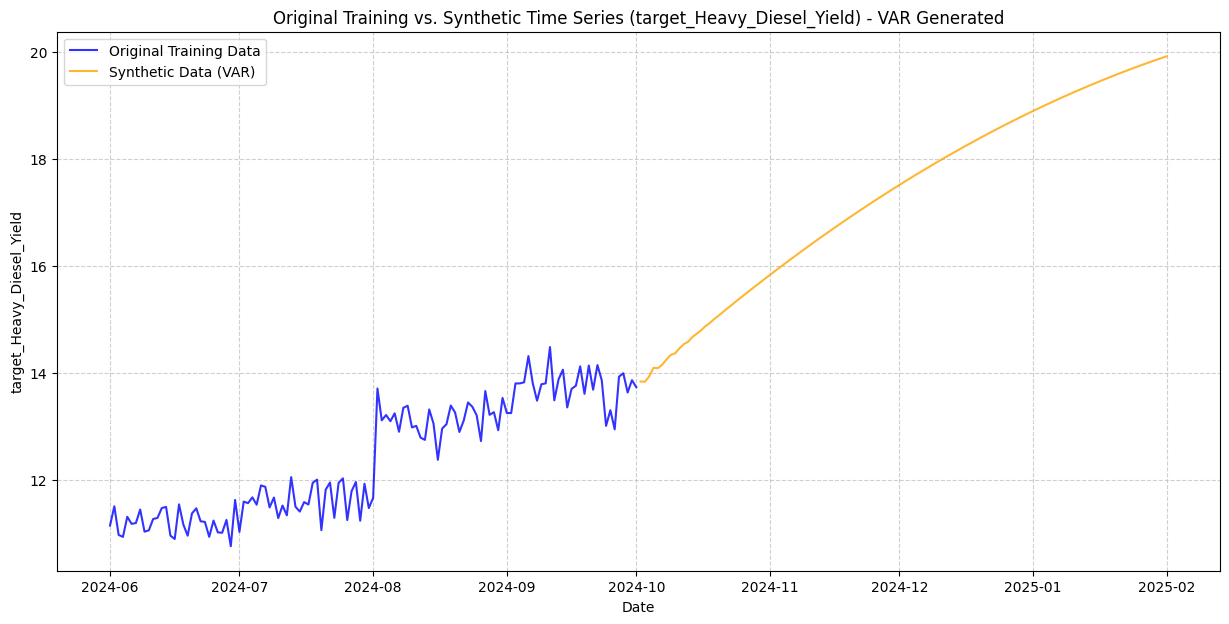


--- Step 11: Saving Augmented DataFrame ---
Ensured output directory exists: /content/drive/MyDrive/VAR_Augmented_Data
Augmented data successfully saved to: /content/drive/MyDrive/VAR_Augmented_Data/augmented_data_var_pca.csv

VAR-based augmentation script finished.


In [2]:
# --- Essential Installs ---
!pip install numpy pandas matplotlib statsmodels scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from statsmodels.tsa.api import VAR # Vector Autoregression
from statsmodels.tsa.stattools import adfuller # Stationarity test
from sklearn.preprocessing import StandardScaler # Keep scaler from PCA step

# --- Mount Google Drive (if using Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
    # Define base path for saving output files
    gdrive_output_base = "/content/drive/MyDrive/" # Adjust if you want a subfolder like '/content/drive/MyDrive/VAR_Output/'
except ImportError:
    print("Not running in Colab or Drive mounting failed. Saving locally.")
    gdrive_output_base = "./" # Save to current directory if not on Colab/Drive

# --- Configuration ---
# How many days of synthetic data to generate?
# n_synthetic_days will be set based on training data length later

# VAR Configuration
var_maxlags = 15
var_selected_lag = None
var_trend = 'c'

# *** SAVE Configuration ***
output_directory_name = "VAR_Augmented_Data" # Name of the folder to create within gdrive_output_base
output_filename = "augmented_data_var_pca.csv" # Name of the output CSV file
save_output = True # Set to False to disable saving

# Construct full output path
output_dir = os.path.join(gdrive_output_base, output_directory_name)
full_save_path = os.path.join(output_dir, output_filename)
# *** End SAVE Configuration ***


# --- Step 1: Load or Access PCA Reduced Data ---
print("--- Step 1: Accessing PCA-Reduced Training Data ---")
# !! IMPORTANT !!
# Assume the PCA script has run and these variables are available:
# - df_train_reduced: DataFrame with targets, future_covs, and PCA past_covs (PC_1, PC_2...)
# - target_cols: List of target column names
# - past_covariate_cols_reduced: List of PCA component column names ('PC_1', 'PC_2', ...)
# - future_covariate_cols: List of future covariate names

# --- Example Placeholder Check ---
try:
    if 'df_train_reduced' in locals() and 'target_cols' in locals() and \
       'past_covariate_cols_reduced' in locals() and 'future_covariate_cols' in locals():
        print("Using df_train_reduced and column lists from previous PCA script.")
        n_synthetic_days = len(df_train_reduced) # Set based on training data length
    else:
        print("Error: PCA results (df_train_reduced, column lists) not found.")
        raise NameError("PCA results not available.")
except NameError as e:
     raise e

# --- Step 2: Select Variables for VAR (Targets + PCA Components) ---
print("\n--- Step 2: Selecting Variables for VAR Model ---")
cols_for_var = target_cols + past_covariate_cols_reduced
df_for_var = df_train_reduced[cols_for_var].copy() # Use the training data
print(f"Selected {len(cols_for_var)} columns for VAR.")


# --- Step 3: Check Stationarity and Apply Differencing ---
print("\n--- Step 3: Checking Stationarity ---")
# ... (Keep the check_stationarity function and differencing loop from the previous VAR script) ...
def check_stationarity(df, significance=0.05):
    results = {}; all_stationary = True; print("Running ADF Test:")
    for name, series in df.items():
        try:
            adf_test = adfuller(series.dropna(), autolag='AIC'); p_value = adf_test[1]
            results[name] = p_value
            if p_value > significance: print(f"  - {name}: Non-stationary (p={p_value:.3f})"); all_stationary = False
            else: print(f"  - {name}: Stationary (p={p_value:.3f})")
        except Exception as e: print(f"  - Error testing {name}: {e}. Skipping."); results[name] = np.nan
    return all_stationary, results

df_diff = df_for_var.copy(); diff_order = 0; max_diff_order = 2
while diff_order < max_diff_order:
    print(f"\nChecking stationarity for differencing order: {diff_order}")
    is_stationary, adf_results = check_stationarity(df_diff)
    if is_stationary: print(f"All series appear stationary at order {diff_order}."); break
    else:
        print(f"Applying differencing (order {diff_order + 1})...")
        if diff_order == 0: first_values_order1 = df_for_var.iloc[0:1]
        if diff_order == 1: first_values_order2_diff = df_for_var.diff().iloc[1:2]
        df_diff = df_diff.diff().dropna(); diff_order += 1
if not is_stationary: print(f"Warning: Could not achieve stationarity.")


# --- Step 4: Fit VAR Model ---
print("\n--- Step 4: Fitting VAR Model ---")
# ... (Keep the VAR model fitting logic, including lag selection) ...
model = VAR(df_diff, freq=df_diff.index.inferred_freq)
if var_selected_lag is None:
    print(f"Selecting lag order automatically (maxlags={var_maxlags})...")
    try:
        selected_orders = model.select_order(maxlags=var_maxlags); print(selected_orders.summary())
        var_selected_lag = selected_orders.aic; print(f"Lag order selected by AIC: {var_selected_lag}")
    except Exception as e: print(f"Error during lag selection: {e}. Defaulting to lag 1."); var_selected_lag = 1
else: print(f"Using pre-defined lag order: {var_selected_lag}")
if var_selected_lag >= len(df_diff): print(f"Warning: Reducing lag."); var_selected_lag = max(1, len(df_diff) // 2)
print(f"Fitting VAR model with {var_selected_lag} lags and trend '{var_trend}'...")
try:
    var_results = model.fit(maxlags=var_selected_lag, ic='aic', trend=var_trend); print(var_results.summary())
except Exception as e: print(f"Error fitting VAR model: {e}"); raise


# --- Step 5: Forecast/Simulate ---
print("\n--- Step 5: Generating Forecasts ---")
# ... (Keep the forecast generation logic) ...
forecast_lag_order = var_results.k_ar; print(f"Model used lag order: {forecast_lag_order}")
last_observations_diff = df_diff.values[-forecast_lag_order:]
print(f"Generating {n_synthetic_days} forecast steps...")
forecast_diff = var_results.forecast(y=last_observations_diff, steps=n_synthetic_days)
forecast_diff_df = pd.DataFrame(forecast_diff, columns=df_diff.columns)


# --- Step 6: Inverse Differencing ---
print("\n--- Step 6: Applying Inverse Differencing ---")
# ... (Keep the inverse_diff_forecast function and application logic) ...
def inverse_diff_forecast(last_orig_row, forecast_diff_df, first_diff_row=None, diff_order=1):
    if diff_order == 0: return forecast_diff_df.copy()
    elif diff_order == 1: return last_orig_row.values + forecast_diff_df.cumsum()
    elif diff_order == 2:
        if first_diff_row is None: raise ValueError("Need first_diff_row for order 2")
        inverted_1st_diff = first_diff_row.values + forecast_diff_df.cumsum()
        last_orig_val = last_orig_row.values
        inverted_orig = last_orig_val + inverted_1st_diff.cumsum()
        return pd.DataFrame(inverted_orig, columns=forecast_diff_df.columns, index=forecast_diff_df.index)
    else: raise NotImplementedError("Inverse difference only up to order 2")

last_orig_row = df_for_var.iloc[-1:]
first_diff_row_for_inv = None
if diff_order == 2: first_diff_row_for_inv = df_for_var.diff().iloc[-1:]
try:
    forecast_undiff_df = inverse_diff_forecast(last_orig_row, forecast_diff_df, first_diff_row_for_inv, diff_order)
except Exception as e: print(f"Error during inverse differencing: {e}"); raise
last_train_date = df_train_reduced.index[-1]
synthetic_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=n_synthetic_days, freq='D')
forecast_undiff_df.index = synthetic_dates
print(f"Inverse differencing complete. Shape: {forecast_undiff_df.shape}")


# --- Step 7: Generate Synthetic Future Covariates ---
print("\n--- Step 7: Generating Synthetic Future Covariates ---")
# ... (Keep the future covariate generation logic) ...
synthetic_future_df = pd.DataFrame(index=synthetic_dates)
if future_covariate_cols:
    for col in future_covariate_cols:
        # !! REPLACE WITH YOUR ACTUAL LOGIC !!
        if 'day_of_week' in col: synthetic_future_df[col] = synthetic_dates.dayofweek
        elif 'month' in col: synthetic_future_df[col] = synthetic_dates.month
        else: print(f"Placeholder logic for future cov: {col}. Assigning 0."); synthetic_future_df[col] = 0
    print(f"Generated {len(future_covariate_cols)} future covariates.")
else: print("No future covariates defined.")


# --- Step 8: Combine Synthetic Parts ---
print("\n--- Step 8: Combining All Synthetic Components ---")
# ... (Keep the combining logic) ...
synthetic_df_complete = pd.concat([forecast_undiff_df, synthetic_future_df], axis=1)
try:
    synthetic_df_complete = synthetic_df_complete[df_train_reduced.columns] # Use original training columns order
    print("Columns reordered to match training data.")
except KeyError as e: print(f"Warning: Column mismatch during reordering: {e}.")


# --- Step 9: Create Augmented DataFrame ---
print("\n--- Step 9: Creating Augmented DataFrame ---")
# ... (Keep the concatenation logic) ...
augmented_df = pd.concat([df_train_reduced, synthetic_df_complete], axis=0).sort_index()
print(f"Original training data shape: {df_train_reduced.shape}")
print(f"Complete synthetic data shape: {synthetic_df_complete.shape}")
print(f"Augmented data shape: {augmented_df.shape}")


# --- Step 10: Evaluation (Visual Check of Targets) ---
print("\n--- Step 10: Evaluating Generated Synthetic Data ---")
# ... (Keep the plotting logic) ...
df_compare_targets_orig = df_train_reduced[target_cols]
if target_cols:
    target_to_plot = target_cols[0]
    if target_to_plot in synthetic_df_complete.columns:
        plt.figure(figsize=(15, 7))
        plt.plot(df_compare_targets_orig.index, df_compare_targets_orig[target_to_plot], label='Original Training Data', color='blue', alpha=0.8)
        plt.plot(synthetic_df_complete.index, synthetic_df_complete[target_to_plot], label='Synthetic Data (VAR)', color='orange', alpha=0.8)
        plt.title(f'Original Training vs. Synthetic Time Series ({target_to_plot}) - VAR Generated')
        plt.ylabel(target_to_plot); plt.xlabel("Date")
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()
    else: print(f"Target column {target_to_plot} not found for plotting.")
else: print("No target columns to plot.")


# --- Step 11: Save Augmented Data ---
print("\n--- Step 11: Saving Augmented DataFrame ---")
if save_output:
    try:
        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        print(f"Ensured output directory exists: {output_dir}")

        # Save the augmented DataFrame to CSV
        # IMPORTANT: index=True preserves the DatetimeIndex
        augmented_df.to_csv(full_save_path, index=True)
        print(f"Augmented data successfully saved to: {full_save_path}")

        # Optional: Save as Parquet for efficiency (requires pyarrow)
        # try:
        #     !pip install pyarrow # Install if needed
        #     parquet_path = os.path.join(output_dir, "augmented_data_var_pca.parquet")
        #     augmented_df.to_parquet(parquet_path, index=True)
        #     print(f"Augmented data also saved as Parquet: {parquet_path}")
        # except Exception as pe:
        #     print(f"Could not save as Parquet: {pe}")

    except Exception as e:
        print(f"Error saving augmented data to {full_save_path}: {e}")
else:
    print("Saving output disabled (save_output=False).")


print("\nVAR-based augmentation script finished.")

AUTO CORRELATION AND CROSS CORRELATION CHECK

--- Step 1: Accessing DataFrames for Comparison ---
Using df_train_reduced and synthetic_df_complete from previous VAR script run.

Variables selected for ACF plots: ['target_Heavy_Diesel_Yield', 'PC_1', 'PC_2', 'PC_3']
Variable pairs selected for CCF plots: [('target_Heavy_Diesel_Yield', 'PC_1'), ('target_Heavy_Diesel_Yield', 'PC_2')]

--- Generating ACF Comparison Plots ---
Plotting ACF for: target_Heavy_Diesel_Yield


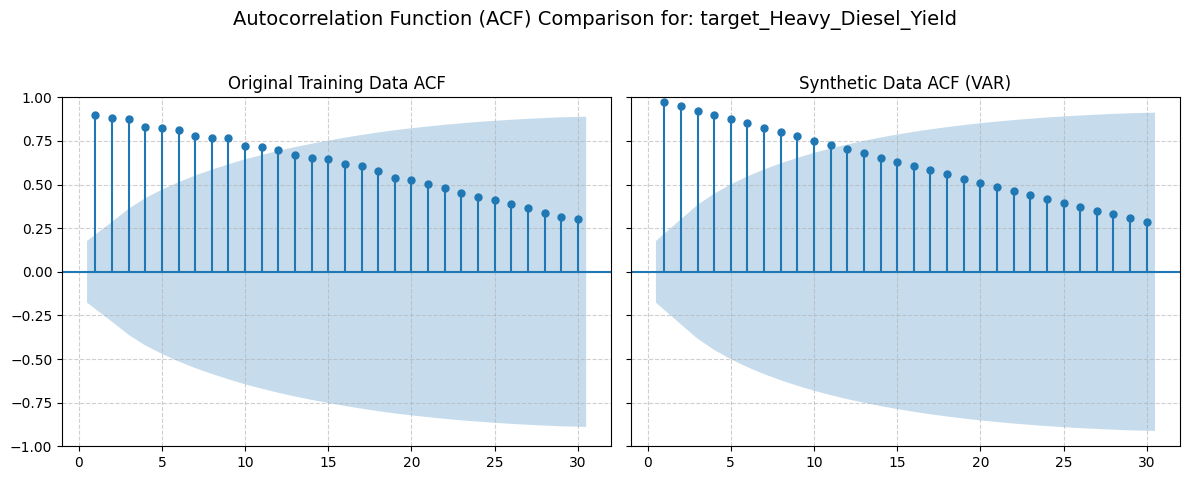

Plotting ACF for: PC_1


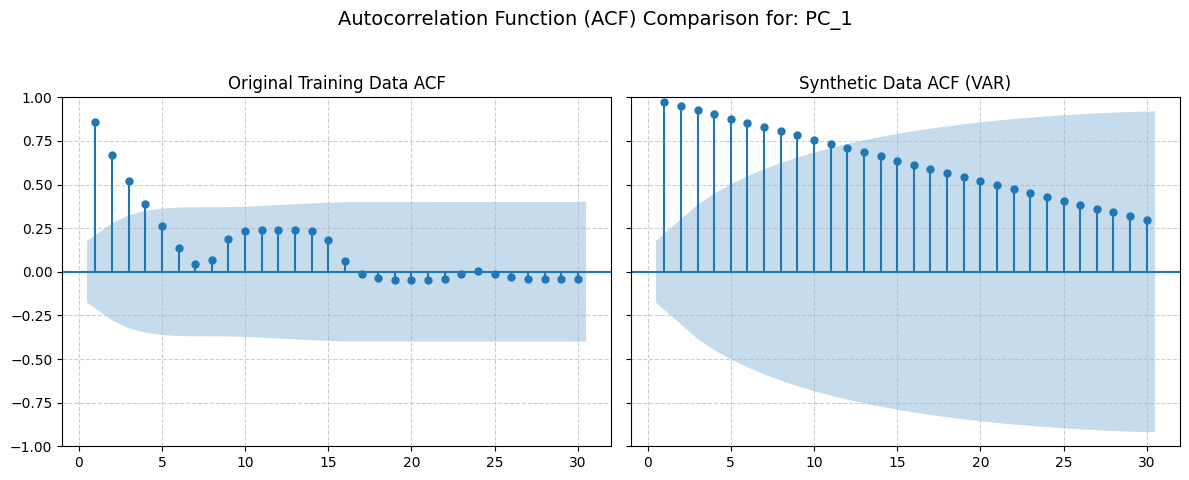

Plotting ACF for: PC_2


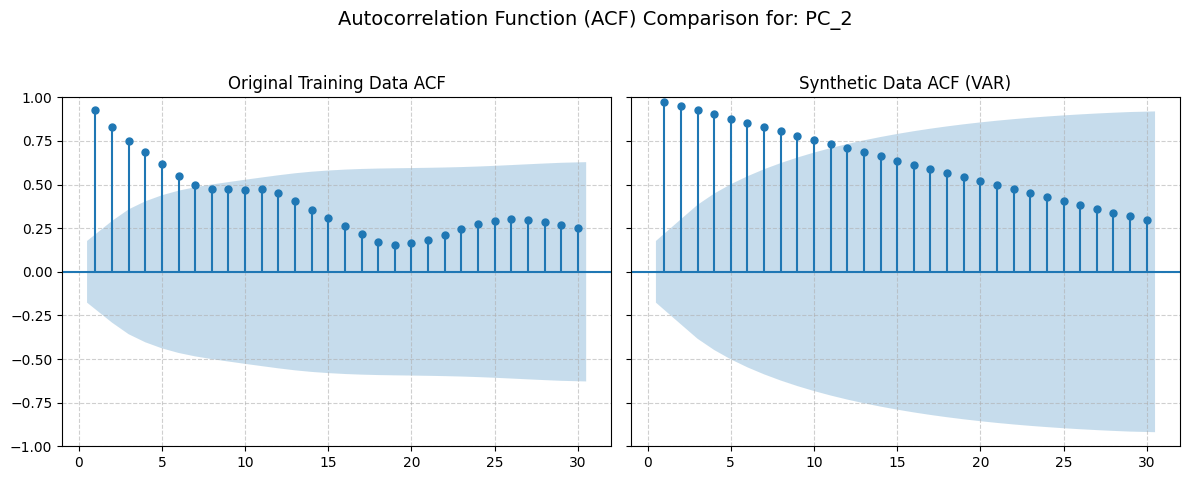

Plotting ACF for: PC_3


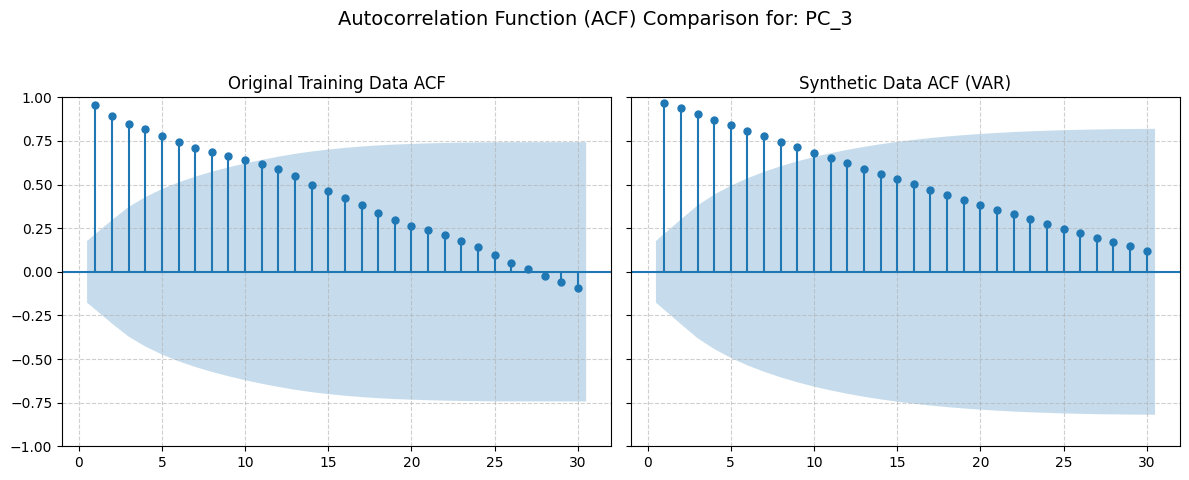


--- Generating CCF Comparison Plots ---
Plotting CCF for: target_Heavy_Diesel_Yield vs PC_1


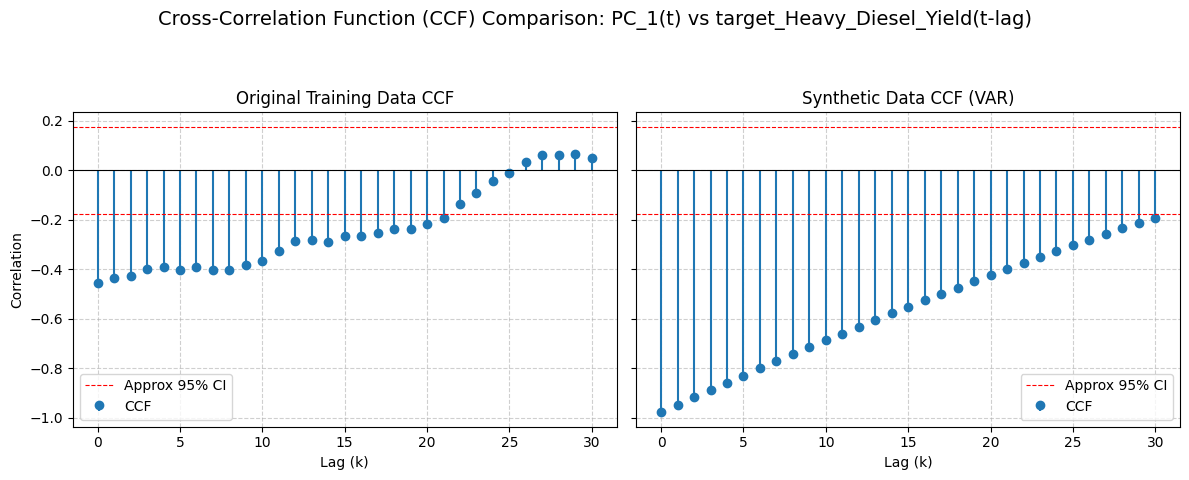

Plotting CCF for: target_Heavy_Diesel_Yield vs PC_2


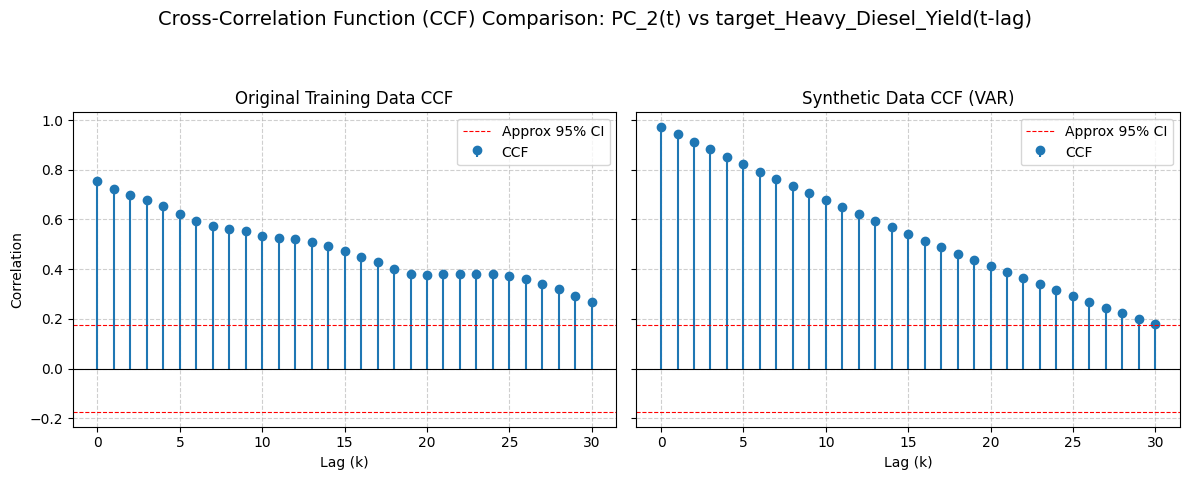


--- Evaluation Complete ---


In [ ]:
# --- Essential Installs ---
# Ensure these libraries are installed
# !pip install numpy pandas matplotlib statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf
import warnings

# --- Configuration ---

# --- Step 1: Access DataFrames and Column Lists ---
print("--- Step 1: Accessing DataFrames for Comparison ---")
# !! IMPORTANT !!
# Ensure these variables are available from your previous VAR script run:
# 1. df_train_reduced: Original training data (Targets, Future Covs, PCA Past Covs)
# 2. synthetic_df_complete: VAR-generated synthetic data (Synth Targets, Synth Future Covs, Synth PCA Past Covs)
# 3. target_cols: List of target column names
# 4. past_covariate_cols_reduced: List of PCA component column names ('PC_1', 'PC_2', ...)

# --- Example Placeholder Check (Replace with loading if run separately) ---
try:
    if 'df_train_reduced' in locals() and 'synthetic_df_complete' in locals() and \
       'target_cols' in locals() and 'past_covariate_cols_reduced' in locals():
        print("Using df_train_reduced and synthetic_df_complete from previous VAR script run.")
    else:
        print("Error: Required DataFrames/lists (df_train_reduced, synthetic_df_complete, etc.) not found.")
        raise NameError("Required data not available.")
except NameError as e:
     raise e

# --- Parameters for Evaluation ---
nlags = 30 # Number of lags to show in ACF/CCF plots (adjust as needed)
alpha = 0.05 # Significance level for confidence intervals

# --- Variables to Evaluate ---
# Select key variables (targets and PCA components) to compare
if not target_cols:
     print("Warning: target_cols list is empty. Cannot perform evaluation.")
     exit()
if not past_covariate_cols_reduced:
    print("Warning: past_covariate_cols_reduced list is empty. Cannot perform CCF evaluation.")

acf_vars_to_plot = [target_cols[0]] # Plot ACF for the first target
if past_covariate_cols_reduced:
     # Plot ACF for the first few principal components (PCs often have less structure)
     acf_vars_to_plot.extend(past_covariate_cols_reduced[:min(3, len(past_covariate_cols_reduced))])

# Select pairs for CCF comparison (e.g., target vs. a PC)
ccf_pairs_to_plot = []
if target_cols and past_covariate_cols_reduced:
    # Target vs first PC
    ccf_pairs_to_plot.append((target_cols[0], past_covariate_cols_reduced[0]))
    # Target vs second PC (if exists)
    if len(past_covariate_cols_reduced) > 1:
         ccf_pairs_to_plot.append((target_cols[0], past_covariate_cols_reduced[1]))
    # Optional: First PC vs Second PC
    # if len(past_covariate_cols_reduced) > 1:
    #     ccf_pairs_to_plot.append((past_covariate_cols_reduced[0], past_covariate_cols_reduced[1]))


print(f"\nVariables selected for ACF plots: {acf_vars_to_plot}")
print(f"Variable pairs selected for CCF plots: {ccf_pairs_to_plot}")

# --- Evaluation Functions (same as before) ---

def plot_acf_comparison(var_name, df_orig, df_synth, nlags, alpha):
    """Plots the ACF for a variable from original and synthetic data side-by-side."""
    if var_name not in df_orig.columns or var_name not in df_synth.columns:
        print(f"Warning: Variable '{var_name}' not found in both DataFrames. Skipping ACF plot.")
        return

    series_orig = df_orig[var_name].dropna()
    series_synth = df_synth[var_name].dropna()

    if len(series_orig) < nlags * 1.5 or len(series_synth) < nlags * 1.5 : # Need sufficient points
         print(f"Warning: Not enough data points for '{var_name}' (Orig: {len(series_orig)}, Synth: {len(series_synth)}) to reliably calculate {nlags} lags. Skipping ACF.")
         return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'Autocorrelation Function (ACF) Comparison for: {var_name}', fontsize=14)

    # Plot ACF for original data
    try:
        plot_acf(series_orig, lags=nlags, alpha=alpha, ax=axes[0], title='Original Training Data ACF', zero=False, fft=False) # Use fft=False for robustness
        axes[0].grid(True, linestyle='--', alpha=0.6)
    except Exception as e:
        axes[0].set_title(f'Original Training ACF (Error: {e})')
        print(f"Error plotting ACF for original {var_name}: {e}")


    # Plot ACF for synthetic data
    try:
        plot_acf(series_synth, lags=nlags, alpha=alpha, ax=axes[1], title='Synthetic Data ACF (VAR)', zero=False, fft=False)
        axes[1].grid(True, linestyle='--', alpha=0.6)
    except Exception as e:
        axes[1].set_title(f'Synthetic Data ACF (Error: {e})')
        print(f"Error plotting ACF for synthetic {var_name}: {e}")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

def plot_ccf_comparison(var1_name, var2_name, df_orig, df_synth, nlags):
    """Plots the CCF between two variables from original and synthetic data."""
    if not all(v in df_orig.columns for v in [var1_name, var2_name]) or \
       not all(v in df_synth.columns for v in [var1_name, var2_name]):
        print(f"Warning: One or both variables '{var1_name}', '{var2_name}' not found in both DataFrames. Skipping CCF plot.")
        return

    # Ensure series are aligned and drop NaNs jointly if needed
    series1_orig = df_orig[var1_name]
    series2_orig = df_orig[var2_name]
    series1_synth = df_synth[var1_name]
    series2_synth = df_synth[var2_name]

    # Drop NaNs carefully
    valid_index_orig = series1_orig.dropna().index.intersection(series2_orig.dropna().index)
    valid_index_synth = series1_synth.dropna().index.intersection(series2_synth.dropna().index)

    series1_orig = series1_orig.loc[valid_index_orig]
    series2_orig = series2_orig.loc[valid_index_orig]
    series1_synth = series1_synth.loc[valid_index_synth]
    series2_synth = series2_synth.loc[valid_index_synth]

    if len(series1_orig) < nlags * 1.5 or len(series1_synth) < nlags * 1.5:
         print(f"Warning: Not enough common non-NaN data points for '{var1_name}' vs '{var2_name}' (Orig: {len(series1_orig)}, Synth: {len(series1_synth)}) to reliably calculate {nlags} lags. Skipping CCF.")
         return

    # Calculate CCF: ccf(x, y) computes corr(y_t, x_{t-k}) for k>=0
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Use adjusted=False for CCF as it's less standard, fft=False for robustness
            ccf_orig = ccf(series1_orig, series2_orig, adjusted=False, fft=False)
            ccf_synth = ccf(series1_synth, series2_synth, adjusted=False, fft=False)
            # Select up to nlags + 1 (lag 0 to nlags)
            ccf_orig = ccf_orig[:nlags+1]
            ccf_synth = ccf_synth[:nlags+1]
    except Exception as e:
        print(f"Error calculating CCF for {var1_name} vs {var2_name}: {e}. Skipping plot.")
        return

    lags_indices = np.arange(len(ccf_orig)) # Lags 0, 1, 2, ... nlags

    # Approximate confidence intervals for CCF
    n_orig = len(series1_orig)
    conf_level = 1.96 / np.sqrt(n_orig) # Approximate 95% CI bounds

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'Cross-Correlation Function (CCF) Comparison: {var2_name}(t) vs {var1_name}(t-lag)', fontsize=14)

    # Plot CCF for original data
    axes[0].stem(lags_indices, ccf_orig, basefmt=" ", linefmt="-", markerfmt="o", label='CCF')
    axes[0].axhline(0, color='black', linewidth=0.8)
    axes[0].axhline(conf_level, color='red', linestyle='--', linewidth=0.8, label='Approx 95% CI')
    axes[0].axhline(-conf_level, color='red', linestyle='--', linewidth=0.8)
    axes[0].set_title('Original Training Data CCF')
    axes[0].set_xlabel('Lag (k)')
    axes[0].set_ylabel('Correlation')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Plot CCF for synthetic data
    axes[1].stem(lags_indices, ccf_synth, basefmt=" ", linefmt="-", markerfmt="o", label='CCF')
    axes[1].axhline(0, color='black', linewidth=0.8)
    axes[1].axhline(conf_level, color='red', linestyle='--', linewidth=0.8, label='Approx 95% CI')
    axes[1].axhline(-conf_level, color='red', linestyle='--', linewidth=0.8)
    axes[1].set_title('Synthetic Data CCF (VAR)')
    axes[1].set_xlabel('Lag (k)')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.92]) # Adjust layout
    plt.show()


# --- Run Evaluation ---

print("\n--- Generating ACF Comparison Plots ---")
for var in acf_vars_to_plot:
    print(f"Plotting ACF for: {var}")
    plot_acf_comparison(var, df_train_reduced, synthetic_df_complete, nlags=nlags, alpha=alpha)

print("\n--- Generating CCF Comparison Plots ---")
if not ccf_pairs_to_plot:
     print("No variable pairs defined for CCF plots.")
else:
    for var1, var2 in ccf_pairs_to_plot:
        print(f"Plotting CCF for: {var1} vs {var2}")
        plot_ccf_comparison(var1, var2, df_train_reduced, synthetic_df_complete, nlags=nlags)

print("\n--- Evaluation Complete ---")

SDV TRIAL

In [ ]:
# --- Essential Installs ---
!pip install numpy pandas matplotlib sdv # Ensure sdv is installed
# !pip install --upgrade darts pytorch_lightning # Only if needed later

from sdv.metadata import Metadata
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json # For printing dictionary if needed

# --- Mount Google Drive (if using Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Colab or Drive mounting failed.")

# --- Configuration ---
# How many days of synthetic data to generate?
# n_synthetic_days = len(df_train_reduced) # Set based on training data used for PCA

# SDV Training parameters
sdv_epochs = 150
sdv_batch_size = 32
datetime_format_string = '%Y-%m-%d %H:%M:%S' # Adjust if your index has no time part '%Y-%m-%d'

# --- Step 1: Load or Access PCA Reduced Data ---
print("--- Step 1: Accessing PCA-Reduced Training Data ---")
# !! IMPORTANT !!
# Assume the PCA script has run and these variables are available:
# - df_train_reduced: DataFrame with targets, future_covs, and PCA past_covs (PC_1, PC_2...)
# - target_cols: List of target column names
# - past_covariate_cols_reduced: List of PCA component column names ('PC_1', 'PC_2', ...)
# - future_covariate_cols: List of future covariate names

# --- Example Placeholder Check ---
try:
    if 'df_train_reduced' in locals() and 'target_cols' in locals() and \
       'past_covariate_cols_reduced' in locals() and 'future_covariate_cols' in locals():
        print("Using df_train_reduced and column lists from previous PCA script.")
        n_synthetic_days = len(df_train_reduced)
    else:
        print("Error: PCA results (df_train_reduced, column lists) not found.")
        raise NameError("PCA results not available.")
except NameError as e:
     raise e

print(f"Training SDV on data with shape: {df_train_reduced.shape}")
print(f"Using {len(target_cols)} target columns and {len(past_covariate_cols_reduced)} PCA past covariates.")

# --- Step 2: Prepare Data for SDV (Targets + PCA Past Covariates + Sequence Key) ---
print("\n--- Step 2: Preparing Data for SDV ---")
cols_to_include = target_cols + past_covariate_cols_reduced # Columns needed from df_train_reduced
print(f"Selecting {len(cols_to_include)} data columns for SDV synthesizer.")

if not target_cols: raise ValueError("Error: No target columns identified.")

# Reset index so 'date' becomes a regular column
if not isinstance(df_train_reduced.index, pd.DatetimeIndex):
    print("Warning: Index of df_train_reduced is not DatetimeIndex.")
df_for_sdv = df_train_reduced[cols_to_include].reset_index()

# Consistently name the date column
date_col_name_sdv = df_for_sdv.columns[0]
if date_col_name_sdv != 'date':
     print(f"Renaming index column from '{date_col_name_sdv}' to 'date'.")
     df_for_sdv = df_for_sdv.rename(columns={date_col_name_sdv: 'date'})
     date_col_name_sdv = 'date'

# *** ADD SEQUENCE KEY COLUMN ***
sequence_key_col_name = 'sequence_id' # Choose a name
df_for_sdv[sequence_key_col_name] = 0 # Assign a constant value
print(f"Added artificial '{sequence_key_col_name}' column for PARSynthesizer.")
# *** END ADD SEQUENCE KEY ***

print(f"Data shape for SDV training (including date and sequence key): {df_for_sdv.shape}")
print(f"Columns for SDV (sample): {df_for_sdv.columns[:4].tolist()}...")

# --- Aggressive Cleaning (Include new sequence key column) ---
print("Applying final cleaning before fitting...")
df_for_sdv = df_for_sdv.ffill().bfill()
df_for_sdv.fillna(0, inplace=True)
df_for_sdv.replace([np.inf, -np.inf], 0, inplace=True)
# Ensure numeric types for targets and PCs
for col in target_cols + past_covariate_cols_reduced:
     if col in df_for_sdv.columns:
          df_for_sdv[col] = pd.to_numeric(df_for_sdv[col], errors='coerce')
# Ensure date type
if date_col_name_sdv in df_for_sdv.columns:
     df_for_sdv[date_col_name_sdv] = pd.to_datetime(df_for_sdv[date_col_name_sdv], errors='coerce')
# Ensure sequence key is integer or object type
if sequence_key_col_name in df_for_sdv.columns:
     df_for_sdv[sequence_key_col_name] = df_for_sdv[sequence_key_col_name].astype(int)
# Final fill after coercion
df_for_sdv.fillna(0, inplace=True)
print(f"Final NaN check: {df_for_sdv.isnull().sum().sum()}")


# --- Step 3: Define Metadata using Auto-Detection and Updates ---
print("\n--- Step 3: Defining SDV Metadata using Auto-Detection ---")
metadata = Metadata()

# --- 3a. Detect metadata from the DataFrame (which includes the sequence key) ---
try:
    print("Attempting metadata auto-detection...")
    metadata.detect_from_dataframe(data=df_for_sdv)
    # Get the automatically assigned table name
    if not metadata.tables:
         raise ValueError("Metadata detection did not create any tables.")
    table_name = list(metadata.tables.keys())[0]
    print(f"Metadata detected. Default table name assigned: '{table_name}'")

    # Print detected columns for verification
    # print("Detected columns and types:")
    # print(metadata.tables[table_name].columns)

except Exception as e:
     print(f"Error during metadata detection: {e}")
     print("Potential issues: Inconsistent data types despite cleaning, extreme values, SDV version bug.")
     raise

# --- 3b. Explicitly set Sequence Index ---
try:
    print(f"Setting sequence index to '{date_col_name_sdv}'...")
    metadata.set_sequence_index(table_name=table_name, column_name=date_col_name_sdv)
except Exception as e:
     print(f"Error setting sequence index '{date_col_name_sdv}' for table '{table_name}': {e}")
     raise

# --- 3c. Explicitly set Sequence Key (Required for PARSynthesizer) ---
try:
    print(f"Setting sequence key to '{sequence_key_col_name}'...")
    metadata.set_sequence_key(table_name=table_name, column_name=sequence_key_col_name)
except Exception as e:
    print(f"Error setting sequence key '{sequence_key_col_name}' for table '{table_name}': {e}")
    # This might happen if detect_from_dataframe didn't recognize the column correctly
    # Try updating its type first
    try:
        print(f"Attempting to update sequence key column '{sequence_key_col_name}' sdtype to 'id'...")
        metadata.update_column(table_name=table_name, column_name=sequence_key_col_name, sdtype='id')
        metadata.set_sequence_key(table_name=table_name, column_name=sequence_key_col_name)
        print("Sequence key set successfully after updating sdtype.")
    except Exception as e2:
        print(f"Still failed to set sequence key after updating sdtype: {e2}")
        raise

# --- 3d. Update Date Column Format ---
try:
    print(f"Updating datetime format for '{date_col_name_sdv}'...")
    metadata.update_column(
        table_name=table_name,
        column_name=date_col_name_sdv,
        sdtype='datetime', # Ensure sdtype is datetime
        datetime_format=datetime_format_string
    )
except Exception as e:
    print(f"Warning: Could not update datetime format for '{date_col_name_sdv}'. Auto-detected format might be used. Error: {e}")

# --- 3e. Verification ---
try:
    seq_index_check = metadata.get_sequence_index(table_name=table_name)
    seq_key_check = metadata.get_sequence_key(table_name=table_name)
    if seq_index_check == date_col_name_sdv:
        print(f"Metadata verification: Sequence index for table '{table_name}' is '{seq_index_check}'")
    else: print(f"Warning: Sequence index verification failed (Expected: {date_col_name_sdv}, Found: {seq_index_check}).")
    if seq_key_check == sequence_key_col_name:
        print(f"Metadata verification: Sequence key for table '{table_name}' is '{seq_key_check}'")
    else: print(f"Warning: Sequence key verification failed (Expected: {sequence_key_col_name}, Found: {seq_key_check}).")
except Exception as e:
     print(f"Error during metadata verification calls: {e}")


# --- Step 4: Initialize and Train Synthesizer ---
print("\n--- Step 4: Initializing and Training PAR Synthesizer ---")
from sdv.sequential import PARSynthesizer

# Use the metadata object configured via auto-detection and updates
synthesizer = PARSynthesizer(metadata=metadata,
                           epochs=sdv_epochs,
                           # batch_size=sdv_batch_size,
                           verbose=True)

df_for_sdv_filled = df_for_sdv # Assign the cleaned df

print("Fitting SDV Synthesizer with auto-detected/updated metadata...")
start_time = time.time()
try:
    synthesizer.fit(data=df_for_sdv_filled)
except Exception as e:
    print(f"Error during synthesizer fitting: {e}")
    # Print metadata structure if fitting fails
    # print("\nMetadata structure at time of error:")
    # print(metadata)
    raise
end_time = time.time()
print(f"Synthesizer training complete. Time taken: {end_time - start_time:.2f} seconds")


# --- Step 5: Generate Synthetic Target and PCA Past Covariates ---
print("\n--- Step 5: Generating Synthetic Sequences ---")
print(f"Generating {n_synthetic_days} steps...")
try:
    synthetic_sequences = synthesizer.sample(num_sequences=1, sequence_length=n_synthetic_days)
except Exception as e:
    print(f"Error during sampling: {e}")
    raise

if isinstance(synthetic_sequences, list):
     print("Warning: Received list output, expected DataFrame. Taking first element.")
     synthetic_tp_pca_df = synthetic_sequences[0]
else:
     synthetic_tp_pca_df = synthetic_sequences

# REMOVE ARTIFICIAL SEQUENCE KEY
if sequence_key_col_name in synthetic_tp_pca_df.columns:
     print(f"Removing artificial '{sequence_key_col_name}' column from synthetic data.")
     synthetic_tp_pca_df = synthetic_tp_pca_df.drop(columns=[sequence_key_col_name])

actual_generated_len = len(synthetic_tp_pca_df)
if actual_generated_len != n_synthetic_days:
    print(f"Warning: Generated length ({actual_generated_len}) differs from requested ({n_synthetic_days}). Using actual length.")
    n_synthetic_days = actual_generated_len
print(f"Generated {actual_generated_len} synthetic steps (targets + PCA components).")
print(f"Synthetic data columns: {synthetic_tp_pca_df.columns.tolist()}")


# --- Step 6: Post-processing - Add Correct Date Index ---
print("\n--- Step 6: Post-processing Synthetic Data ---")
# (Keep this section the same as the manual metadata version)
# ... (Code to add date index) ...
last_train_date = df_train_reduced.index[-1]
synthetic_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1),
                                periods=n_synthetic_days, freq='D')
if date_col_name_sdv not in synthetic_tp_pca_df.columns:
     print(f"Error: Date column '{date_col_name_sdv}' not found in synthetic data columns: {synthetic_tp_pca_df.columns}")
     date_col_name_to_use = synthetic_tp_pca_df.columns[0] # Fallback
else:
     date_col_name_to_use = date_col_name_sdv
print(f"Assigning sequential dates and setting index using column '{date_col_name_to_use}'...")
synthetic_tp_pca_df[date_col_name_to_use] = synthetic_dates
synthetic_tp_pca_df = synthetic_tp_pca_df.set_index(date_col_name_to_use).sort_index()
print("Synthetic data indexed by date.")


# --- Step 7: Evaluation (Targets Only) ---
print("\n--- Step 7: Evaluating Generated Synthetic Data (Targets vs Original Training Targets) ---")
# (Keep this section the same as the manual metadata version)
# ... (Code for plotting comparison) ...
df_compare_targets_orig = df_train_reduced[target_cols]
if target_cols:
    target_to_plot = target_cols[0]
    print(f"Plotting comparison for target: {target_to_plot}")
    if target_to_plot not in synthetic_tp_pca_df.columns:
        print(f"Error: Target column '{target_to_plot}' not found in synthetic data.")
    else:
        plt.figure(figsize=(15, 7))
        plt.plot(df_compare_targets_orig.index, df_compare_targets_orig[target_to_plot], label='Original Training Data', color='blue', alpha=0.8)
        plt.plot(synthetic_tp_pca_df.index, synthetic_tp_pca_df[target_to_plot], label='Synthetic Data', color='green', alpha=0.8) # Changed color
        plt.title(f'Original Training vs. Synthetic Time Series ({target_to_plot}) - SDV Generated (Auto Meta)')
        plt.ylabel(target_to_plot); plt.xlabel("Date")
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()
        plt.figure(figsize=(10, 5))
        df_compare_targets_orig[target_to_plot].hist(alpha=0.6, label='Original Training', bins=30, density=True)
        synthetic_tp_pca_df[target_to_plot].hist(alpha=0.6, label='Synthetic', bins=30, density=True)
        plt.title(f'Distribution Comparison ({target_to_plot}) - SDV Generated (Auto Meta)')
        plt.legend(); plt.show()
else:
    print("No target columns found to plot.")


# --- Step 8: Prepare for Full Augmentation (Manual Steps Required) ---
print("\n--- Step 8: Preparing for Full Augmentation ---")
# (Keep notes as before)
# ... (Notes on generating future covs and combining) ...

print("\nSDV script with auto metadata detection finished.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
--- Step 1: Accessing PCA-Reduced Training Data ---
Using df_train_reduced and column lists from previous PCA script.
Training SDV on data with shape: (123, 45)
Using 12 target columns and 28 PCA past covariates.

--- Step 2: Preparing Data for SDV ---
Selecting 40 data columns for SDV synthesizer.
Added artificial 'sequence_id' column for PARSynthesizer.
Data shape for SDV training (including date and sequence key): (123, 42)
Columns for SDV (sample): ['date', 'target_Heavy_Diesel_Yield', 'target_Heavy_Diesel_flow', 'target_Kero_Yield']...
Applying final cleaning before fitting...
Final NaN check: 0

--- Step 3: Defining SDV Metadata using Auto-Detection ---
Attempting metadata auto-detection...
Error during metadata detection: Metadata detection did not create any tables.
Potential issues: Inconsistent data types despite c

ValueError: Metadata detection did not create any tables.